In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import seaborn as sns
from utils.visualize import custom_histogram
from sklearn.model_selection import train_test_split

# Categorical data preparation

## 1.Load data

In [2]:
data_dir = '../data/raw/'
files = os.listdir(data_dir)
for i, v in enumerate(files):
    print(i, v)

0 38_sick_train.csv
1 38_sick_test.csv


In [3]:
train = pd.read_csv(data_dir + files[0])
print("Dimensions: {}".format(train.shape))
print("Columns: {}".format(', '.join(train.columns)))
train.head()

Dimensions: (3018, 31)
Columns: d3mIndex, age, sex, on_thyroxine, query_on_thyroxine, on_antithyroid_medication, sick, pregnant, thyroid_surgery, I131_treatment, query_hypothyroid, query_hyperthyroid, lithium, goitre, tumor, hypopituitary, psych, TSH_measured, TSH, T3_measured, T3, TT4_measured, TT4, T4U_measured, T4U, FTI_measured, FTI, TBG_measured, TBG, referral_source, Class


,d3mIndex,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,0,41.0,F,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,2,46.0,M,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
2,3,70.0,F,t,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
3,5,18.0,F,t,f,f,f,f,f,f,...,t,183.0,t,1.30,t,141.0,f,NaN,other,negative
4,6,59.0,F,f,f,f,f,f,f,f,...,t,72.0,t,0.92,t,78.0,f,NaN,other,negative


In [4]:
# Since column 'd3mIndex' can be ignored, drop 
train.drop(columns=['d3mIndex'], inplace=True)

In [5]:
train.dtypes

age                          float64
sex                           object
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH_measured                  object
TSH                          float64
T3_measured                   object
T3                           float64
TT4_measured                  object
TT4                          float64
T4U_measured                  object
T4U                          float64
FTI_measured                  object
FTI                          float64
TBG_measured                  object
T

## 2. Data distribution

In [6]:
# Check Sparsity of data
for c in train.columns: 
    missing = train[c].isna().sum()
    if missing > 0: 
        print('{} - dtype: {}'.format(c, train.dtypes.loc[c]))
        print("missing: {}".format(missing))
        print("percent: {:1.4f}".format((missing/train.shape[0]) * 100))
#     else:
#         print(c)
#         print('No missing values\n')

age - dtype: float64
missing: 1
percent: 0.0331
sex - dtype: object
missing: 125
percent: 4.1418
TSH - dtype: float64
missing: 295
percent: 9.7747
T3 - dtype: float64
missing: 604
percent: 20.0133
TT4 - dtype: float64
missing: 184
percent: 6.0968
T4U - dtype: float64
missing: 326
percent: 10.8019
FTI - dtype: float64
missing: 324
percent: 10.7356
TBG - dtype: float64
missing: 3018
percent: 100.0000


In [17]:
train[train['Class'] == 'sick'].value

AttributeError: 'DataFrame' object has no attribute 'value_conuts'

In [34]:
# Drop Column TBG since it is missing all data. 
train.drop(columns=['TBG'], inplace=True)

In [35]:
# Visualize countplots for all categorical variables 
columns_cat = [] 

for i in train.dtypes.index:
    if train.dtypes.loc[i] == 'object':
        columns_cat.append(i)

In [36]:
# Generate subplot grid coordinates
axis_keys = [] 
for i in list(range(5)):
    for j in list(range(0,5)):
        axis_keys.append((i,j))

axis_keys[:5]

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]

In [37]:
# Map column to grid coordinates
subplot_data = {}
for i, v in enumerate(columns_cat):
    subplot_data[v] = axis_keys[i]

subplot_data

{'sex': (0, 0),
 'on_thyroxine': (0, 1),
 'query_on_thyroxine': (0, 2),
 'on_antithyroid_medication': (0, 3),
 'sick': (0, 4),
 'pregnant': (1, 0),
 'thyroid_surgery': (1, 1),
 'I131_treatment': (1, 2),
 'query_hypothyroid': (1, 3),
 'query_hyperthyroid': (1, 4),
 'lithium': (2, 0),
 'goitre': (2, 1),
 'tumor': (2, 2),
 'hypopituitary': (2, 3),
 'psych': (2, 4),
 'TSH_measured': (3, 0),
 'T3_measured': (3, 1),
 'TT4_measured': (3, 2),
 'T4U_measured': (3, 3),
 'FTI_measured': (3, 4),
 'TBG_measured': (4, 0),
 'referral_source': (4, 1),
 'Class': (4, 2)}

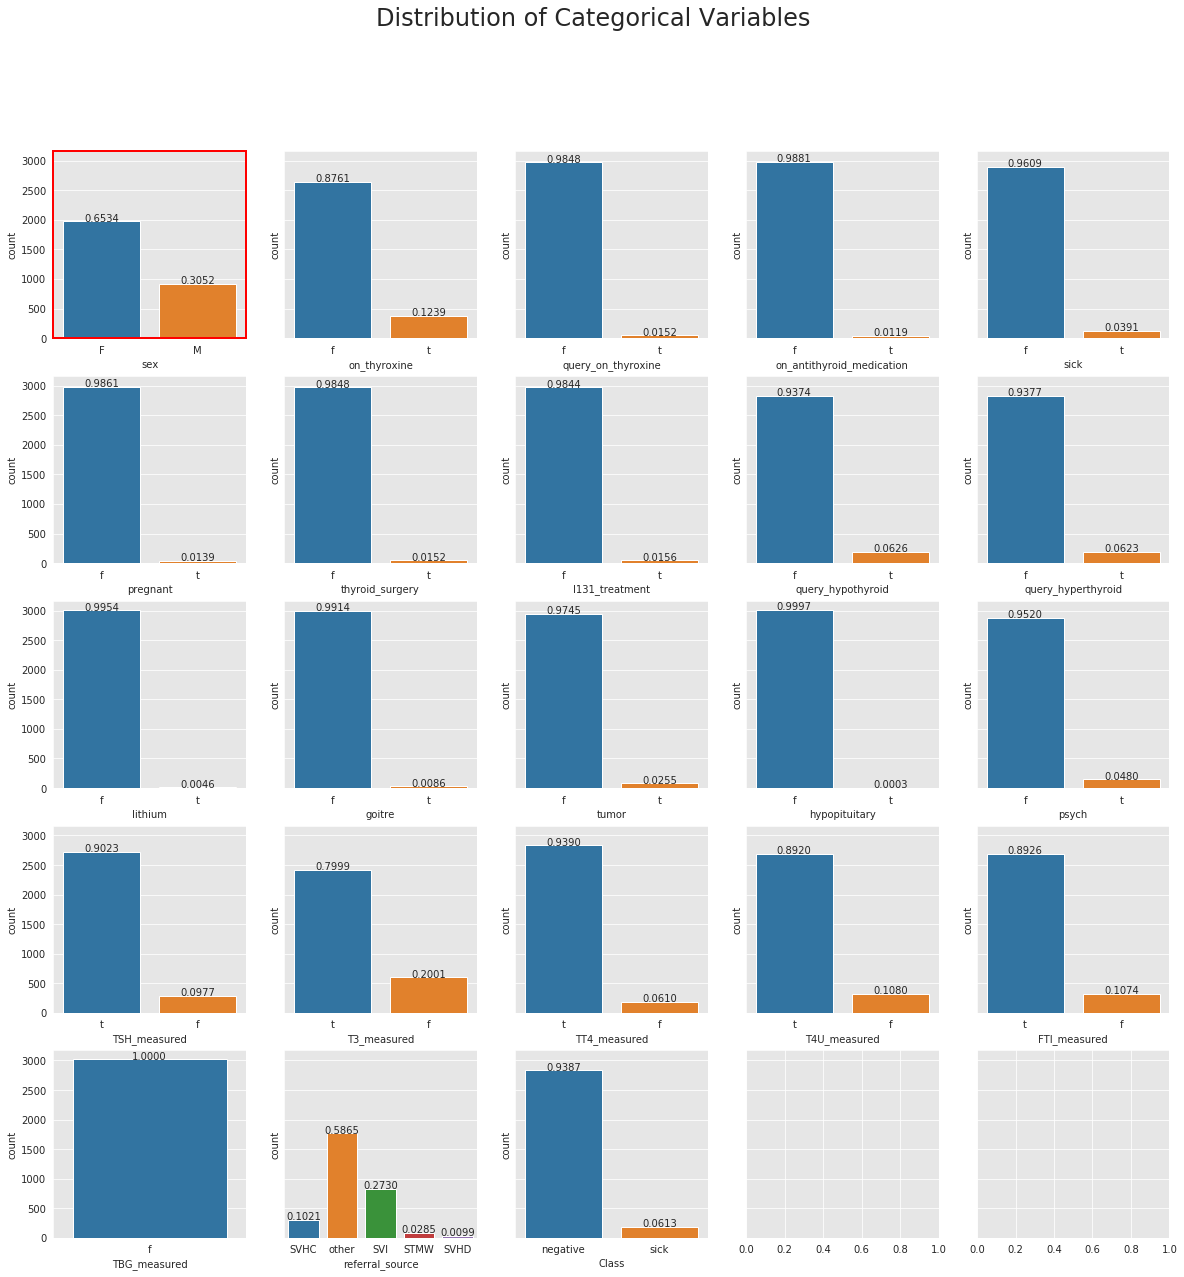

In [38]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(20,20), nrows=round(len(columns_cat)/5), ncols=5, sharey=True)
fig.suptitle('Distribution of Categorical Variables', fontsize=24)

# Specify data for each subplot by iterating through the dict
# with column id as key and axis coordinates as values
for k, v in subplot_data.items():
    ax_sub = sns.countplot(train[k], ax=ax[v])
    y_vals  = [] 
    for p in ax_sub.patches:
        # y-axis value 
        height = p.get_height()
        y_vals.append(height)
        ax_sub.text(p.get_x()+p.get_width()/2.0,
                height+3, 
                '{:1.4f}'.format(height/train.shape[0]),
                ha='center')
    
    # If the combined y is less than the total number of rows in the original table, 
    # There are missing values in that column
    # Highlight that border in red 
    if sum(y_vals) < train.shape[0]:
        for spine in ax_sub.spines:
            ax_sub.spines[spine].set_color('red')
            ax_sub.spines[spine].set_linewidth(2)

plt.show()
fig.savefig('../images/categorical_countplot.png')

Observing all of the categorical variables reveals the following information:
- [x] Majority of categories are very imbalanced --> think about how this can affect model performance. Due to its scarcity models may treat these as 'noise'. 
- [x] The column 'sex' is missing some values --> fix with one hot encoding 
- [x] All patients are false for 'TBG_measured' --> no predictive value, thus remove.
- [x] All of the columns with `{<test_name>}_measured` are true if the corresponding `<test_name>` column has some measurement value. When these columns are 'false' the value in the `<test_name>` column is Nan.  Drop these categories since they do not add any value.
- [x] One hot encode all 't'/'f' binary columns
- [x] Referral source will become sparse if one hot encoded. Possible it will just become noise. Train the model with these variables, train without, and compare performance. 

In [39]:
# Drop Column TBG since it is missing all data. 
train.drop(columns=['TBG_measured'], inplace=True)

In [40]:
# One Hot Encoding on 'sex' Column
# This fixes the issue of having missing values
# The nan columns are now represented as [0, 0] in [M, F] columns
train.insert(loc=2, column='F', value=pd.get_dummies(train.sex)['F'])
train.insert(loc=2, column='M', value=pd.get_dummies(train.sex)['M'])
train.drop(columns=['sex'], axis=1, inplace=True)
train.head()

,age,M,F,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
0,41.0,0,1,f,f,f,f,f,f,f,...,t,2.5,t,125.0,t,1.14,t,109.0,SVHC,negative
1,46.0,1,0,f,f,f,f,f,f,f,...,f,NaN,t,109.0,t,0.91,t,120.0,other,negative
2,70.0,0,1,t,f,f,f,f,f,f,...,t,1.9,t,175.0,f,NaN,f,NaN,other,negative
3,18.0,0,1,t,f,f,f,f,f,f,...,f,NaN,t,183.0,t,1.30,t,141.0,other,negative
4,59.0,0,1,f,f,f,f,f,f,f,...,f,NaN,t,72.0,t,0.92,t,78.0,other,negative


In [41]:
# Remove the 'measured' columns
measured_cols = [col for col in train.columns if 'measured' in col]
train.drop(columns=measured_cols, inplace=True)

In [42]:
# Convert 't' and 'f' values to binary
columns_binary = columns_cat[1:15]
train[columns_binary].describe()

,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych
count,3018,3018,3018,3018,3018,3018,3018,3018,3018,3018,3018,3018,3018,3018
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,f,f,f,f,f,f,f,f,f,f,f,f,f,f
freq,2644,2972,2982,2900,2976,2972,2971,2829,2830,3004,2992,2941,3017,2873


In [43]:
for i in columns_binary:
    train[i] = train[i].astype('category')
    train[i] = train[i].cat.codes

train[columns_binary].describe().loc[['max', 'min']]

,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# One hot encode referral source 
print('Unique entires in referral source column: {}'.format(', '.join(train.referral_source.unique())))
one_hot = pd.get_dummies(train.referral_source)

Unique entires in referral source column: SVHC, other, SVI, STMW, SVHD


In [45]:
train.drop(columns=['referral_source'], inplace=True)
train = train.join(one_hot)
train.dtypes

age                          float64
M                              uint8
F                              uint8
on_thyroxine                    int8
query_on_thyroxine              int8
on_antithyroid_medication       int8
sick                            int8
pregnant                        int8
thyroid_surgery                 int8
I131_treatment                  int8
query_hypothyroid               int8
query_hyperthyroid              int8
lithium                         int8
goitre                          int8
tumor                           int8
hypopituitary                   int8
psych                           int8
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
Class                         object
STMW                           uint8
SVHC                           uint8
SVHD                           uint8
SVI                            uint8
o

In [46]:
# Convert all 'uint8' to numpy 'int8' dtype
for c in train.columns:
    dtype = train.dtypes.loc[c]
    if str(dtype) in ['uint8', 'int8']:
        train[c] = train[c].astype(np.int8)

train.dtypes

age                          float64
M                               int8
F                               int8
on_thyroxine                    int8
query_on_thyroxine              int8
on_antithyroid_medication       int8
sick                            int8
pregnant                        int8
thyroid_surgery                 int8
I131_treatment                  int8
query_hypothyroid               int8
query_hyperthyroid              int8
lithium                         int8
goitre                          int8
tumor                           int8
hypopituitary                   int8
psych                           int8
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
Class                         object
STMW                            int8
SVHC                            int8
SVHD                            int8
SVI                             int8
o

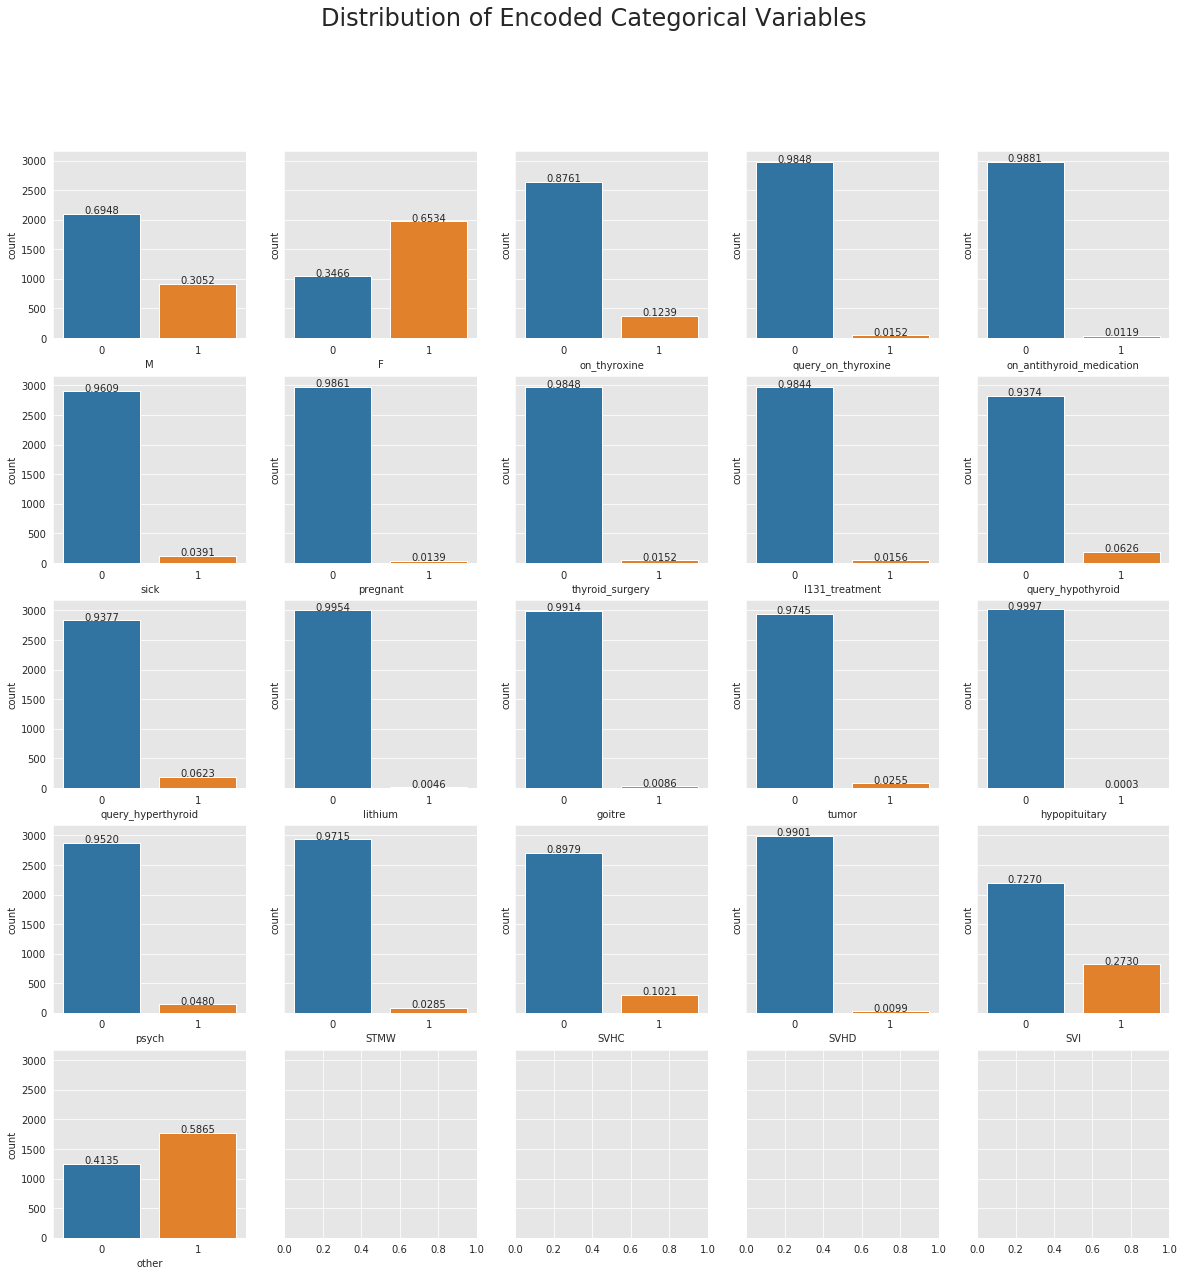

In [47]:
# Check the distribution of coded categories 
columns_cat = [] 

for i in train.dtypes.index:
    if train.dtypes.loc[i] == 'int8':
        columns_cat.append(i)

# Generate subplot grid coordinates 
axis_keys = [] 
for i in list(range(0,5)):
    for j in list(range(0,5)):
        axis_keys.append((i,j))

# Map column to grid coordinates        
subplot_data = {}
for i, v in enumerate(columns_cat):
    subplot_data[v] = axis_keys[i]

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(20,20), nrows=5, ncols=5, sharey=True)
fig.suptitle('Distribution of Encoded Categorical Variables', fontsize=24)

# Specify data for each subplot by iterating through the dict
# with column id as key and axis coordinates as values
for k, v in subplot_data.items():
    ax_sub = sns.countplot(train[k], ax=ax[v])
    y_vals  = [] 
    for p in ax_sub.patches:
        # y-axis value 
        height = p.get_height()
        y_vals.append(height)
        ax_sub.text(p.get_x()+p.get_width()/2.0,
                height+3, 
                '{:1.4f}'.format(height/train.shape[0]),
                ha='center')
    
    # If the combined y is less than the total number of rows in the original table, 
    # There are missing values in that column
    # Highlight that border in red 
    if sum(y_vals) < train.shape[0]:
        for spine in ax_sub.spines:
            ax_sub.spines[spine].set_color('red')
            ax_sub.spines[spine].set_linewidth(2)

plt.show()
fig.savefig('../images/categorical_countplot2.png')

In [48]:
# Visualize all continuous variables 
columns_cont = [] 

for i in train.dtypes.index:
    if train.dtypes.loc[i] == 'float64':
        columns_cont.append(i)

In [49]:
train[columns_cont].dtypes

age    float64
TSH    float64
T3     float64
TT4    float64
T4U    float64
FTI    float64
dtype: object

<Figure size 1440x1440 with 0 Axes>

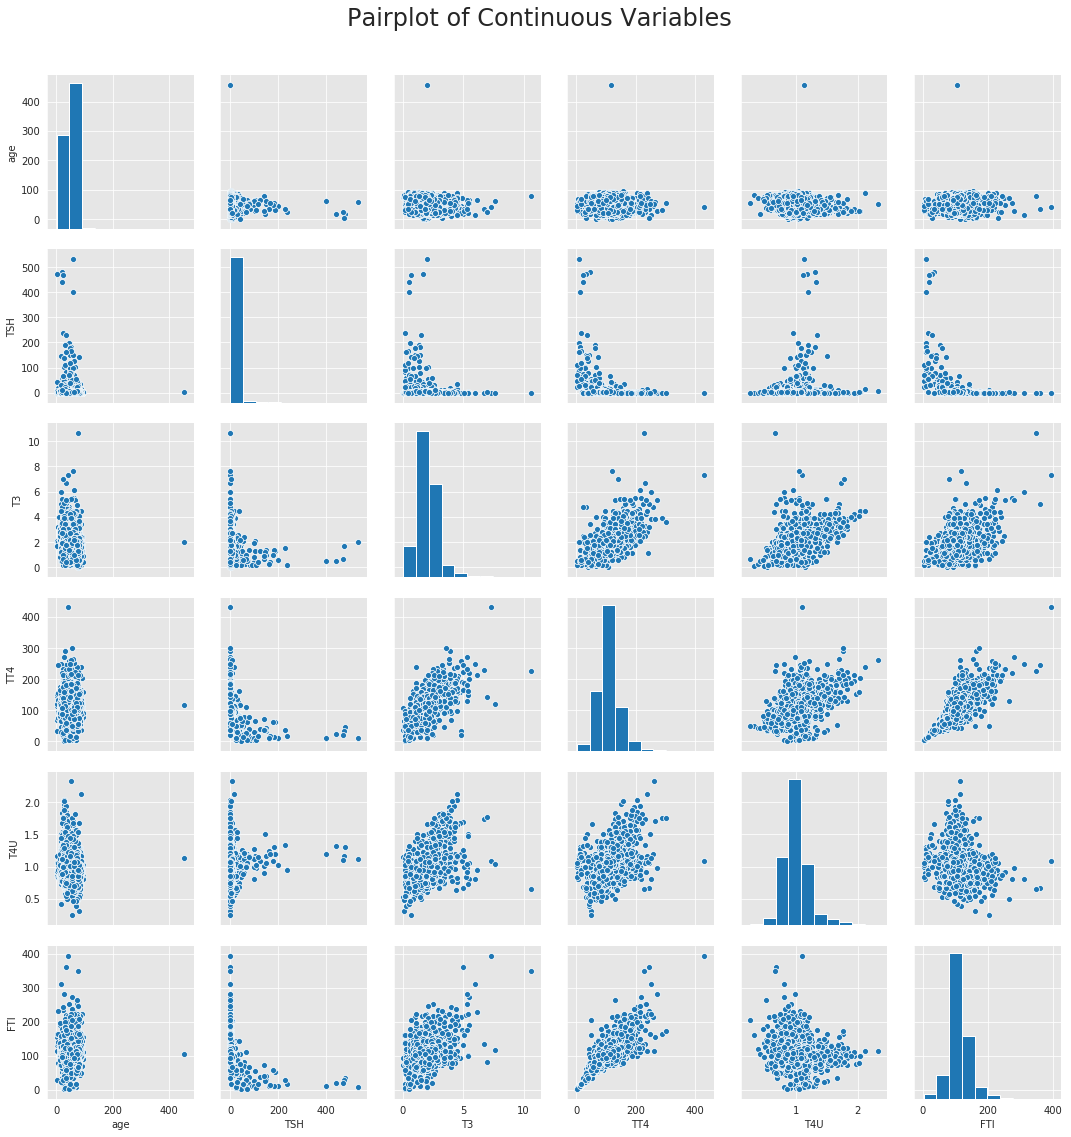

In [50]:
plt.figure(figsize=(20,20))

fig = sns.pairplot(data=train[columns_cont])
fig.fig.suptitle('Pairplot of Continuous Variables', y=1.05, fontsize=24)
fig.savefig('../images/pairplot_continous_variables.png')

From the pairplots, we can see that there seems to be an outlier for the age category. 

In [51]:
train[train['age'] >100]

,age,M,F,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,...,T3,TT4,T4U,FTI,Class,STMW,SVHC,SVHD,SVI,other
1101,455.0,0,1,0,0,0,0,0,0,0,...,2.0,118.0,1.13,104.0,negative,0,0,0,1,0


In [52]:
# Drop this row and reset index 
train.drop(index=1101, inplace=True)
train.reset_index(inplace=True, drop=True)

## Create development set before handling missing continuous values

In [53]:
train.head()

,age,M,F,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,...,T3,TT4,T4U,FTI,Class,STMW,SVHC,SVHD,SVI,other
0,41.0,0,1,0,0,0,0,0,0,0,...,2.5,125.0,1.14,109.0,negative,0,1,0,0,0
1,46.0,1,0,0,0,0,0,0,0,0,...,NaN,109.0,0.91,120.0,negative,0,0,0,0,1
2,70.0,0,1,1,0,0,0,0,0,0,...,1.9,175.0,NaN,NaN,negative,0,0,0,0,1
3,18.0,0,1,1,0,0,0,0,0,0,...,NaN,183.0,1.30,141.0,negative,0,0,0,0,1
4,59.0,0,1,0,0,0,0,0,0,0,...,NaN,72.0,0.92,78.0,negative,0,0,0,0,1


In [54]:
# Separate X and y 
y = train['Class'].to_frame()
train.drop(columns=['Class'], inplace=True)
X = train

In [55]:
X.head()

,age,M,F,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,...,TSH,T3,TT4,T4U,FTI,STMW,SVHC,SVHD,SVI,other
0,41.0,0,1,0,0,0,0,0,0,0,...,1.30,2.5,125.0,1.14,109.0,0,1,0,0,0
1,46.0,1,0,0,0,0,0,0,0,0,...,0.98,NaN,109.0,0.91,120.0,0,0,0,0,1
2,70.0,0,1,1,0,0,0,0,0,0,...,0.16,1.9,175.0,NaN,NaN,0,0,0,0,1
3,18.0,0,1,1,0,0,0,0,0,0,...,0.03,NaN,183.0,1.30,141.0,0,0,0,0,1
4,59.0,0,1,0,0,0,0,0,0,0,...,NaN,NaN,72.0,0.92,78.0,0,0,0,0,1


In [56]:
# Specify directory
temp_data_dir = '../data/temp/'

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=1)

# Save data 
X_train.to_csv(temp_data_dir + 'X_train.csv')
y_train.to_csv(temp_data_dir + 'y_train.csv')
X_dev.to_csv(temp_data_dir + 'X_dev.csv')
y_dev.to_csv(temp_data_dir + 'y_dev.csv')